In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib

# loading data 

In [75]:
df=pd.read_csv('shuffled_output.csv')

In [76]:
df

,unit weight(kN/m3),Cohesion(kPa),internal friction angle,Slope angle,slope height (m),pore pressure ratio,Status
0,26.80,37.50,32.00,30.0,26.00,0.00,Stable
1,17.60,10.00,8.00,21.8,9.00,0.40,Stable
2,26.89,150.00,33.00,52.0,120.00,0.25,Stable
3,16.05,11.49,0.00,30.0,3.66,0.00,Failure
4,27.00,40.00,35.00,47.1,292.00,0.25,Failure
...,...,...,...,...,...,...,...
387,21.43,0.00,20.00,20.0,61.00,0.00,Failure
388,25.80,43.30,37.00,30.0,33.00,0.00,Stable
389,18.80,8.00,26.00,21.8,40.00,0.40,Failure
390,22.93,32.33,19.73,30.0,50.00,1.00,Stable


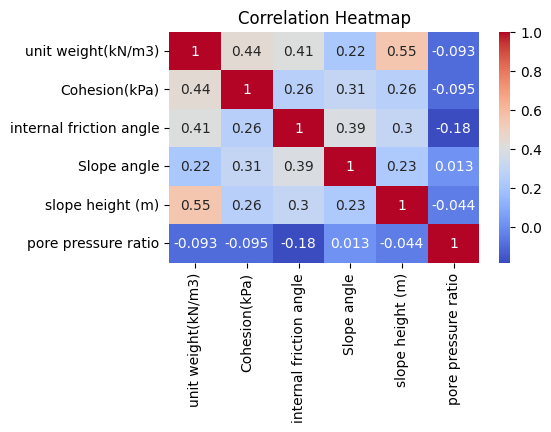

In [77]:
plt.figure(figsize=(5,3))
df2=df.drop(['Status'],axis=1)
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [79]:
X = df.drop('Status', axis=1)
y= df['Status'] 

#____________________categorical encoding____________________

mapping = {'Stable': 1, 'Failure': 0}
y=y.map(mapping)
y.value_counts()

#__________________________________________________________________
#__________________________treain test split__________________________
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#________________________________________________________________________________________

# #__________________________feature scaling__________________________
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [84]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# hyper parameter tunning 

In [80]:
n_estimators=[int(x) for x in np.linspace(start=50, stop=1000, num=20)]
max_depth=[3, 4, 5, 6]
learning_rate=[0.01, 0.1, 0.2, 0.3]
subsample=[0.6, 0.8, 1.0]
gamma=[0, 0.1, 0.2, 0.5]
reg_alpha = [0, 0.01, 0.1]
reg_lambda = [1, 5, 10]
random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'subsample': subsample,
    'gamma': gamma,
    'reg_alpha': reg_alpha,
    'reg_lambda': reg_lambda
    
}

model=XGBClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=150, cv=6, random_state=42, n_jobs=1)
random_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=6,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=150, n_jobs=1,
                   param_distributions={'gamma': [0, 0.1, 0.2, 0.5],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500, 550, 600, 650,
                                                         700, 750, 800, 850,
                                                         900, 950, 1000],
                                        'reg_alpha': [0, 0.01, 0.1],
                                        'reg_lambda': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42)

In [83]:

y_pred = random_search.predict(X_test_scaled)
accuracy = random_search.score(X_test_scaled, y_test)
train_accuracy = random_search.score(X_train_scaled, y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(random_search.best_params_)
print(f'the best score after hyper parametr tuning { random_search.best_score_}')

Train Accuracy: 0.9617
Accuracy: 0.8481
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        36
           1       0.88      0.84      0.86        43

    accuracy                           0.85        79
   macro avg       0.85      0.85      0.85        79
weighted avg       0.85      0.85      0.85        79

Confusion Matrix:
[[31  5]
 [ 7 36]]
{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.5}
the best score after hyper parametr tuning 0.8370222544750847


In [82]:
joblib.dump(random_search, 'xgb_random_search.pkl')

['xgb_random_search.pkl']